# Generative Adversarial Networks for Beginners
## Build a neural network that learns to generate handwritten digits.
### By [Jon Bruner](https://github.com/jonbruner) and [Adit Deshpande](https://github.com/adeshpande3)

This notebook accompanies [the O'Reilly interactive tutorial on generative adversarial networks](https://www.oreilly.com/learning/generative-adversarial-networks-for-beginners). See the original tutorial to run this code in a pre-built environment on O'Reilly's servers with cell-by-cell guidance, or run this notebook on your own machine.

Also, see [gan-script.py](gan-script.py) in this repository for a straight Python implementation of this code.

### Prerequisites

You'll need [TensorFlow](https://www.tensorflow.org/install/), [NumPy](https://docs.scipy.org/doc/numpy/user/install.html), [matplotlib](https://matplotlib.org/) and [Jupyter](https://jupyter.readthedocs.io/en/latest/install.html) in order to run this notebook on your machine. See [the readme](https://github.com/jonbruner/generative-adversarial-networks) for advice on installing these packages.

## Introduction

According to Yann LeCun, “adversarial training is the coolest thing since sliced bread.” Sliced bread certainly never created this much excitement within the deep learning community. Generative adversarial networks—or GANs, for short—have dramatically sharpened the possibility of AI-generated content, and have drawn active research efforts since they were [first described by Ian Goodfellow et al. in 2014](https://arxiv.org/abs/1406.2661).

GANs are neural networks that learn to create synthetic data similar to some known input data. For instance, researchers have generated convincing images from [photographs of everything from bedrooms to album covers](https://github.com/Newmu/dcgan_code), and they display a remarkable ability to reflect [higher-order semantic logic](https://github.com/Newmu/dcgan_code).

Those examples are fairly complex, but it's easy to build a GAN that generates very simple images. In this tutorial, we'll build a GAN that analyzes lots of images of handwritten digits and gradually learns to generate new images from scratch—*essentially, we'll be teaching a neural network how to write*.

<img src="notebook-images/gan-animation.gif" />
_Sample images from the generative adversarial network that we'll build in this tutorial. During training, it gradually refines its ability to generate digits._

## GAN architecture

Generative adversarial networks consist of two models: a generative model and a discriminative model.

![caption](notebook-images/GAN_Overall.png)

The discriminator model is a classifier that determines whether a given image looks like a real image from the dataset or like an artificially created image. This is basically a binary classifier that will take the form of a normal convolutional neural network (CNN).

The generator model takes random input values and transforms them into images through a deconvolutional neural network.

Over the course of many training iterations, the weights and biases in the discriminator and the generator are trained through backpropagation. The discriminator learns to tell "real" images of handwritten digits apart from "fake" images created by the generator. At the same time, the generator uses feedback from the discriminator to learn how to produce convincing images that the discriminator can't distinguish from real images.

## Getting started

We’re going to create a GAN that will generate handwritten digits that can fool even the best classifiers (and humans too, of course). We'll use [TensorFlow](https://www.tensorflow.org/), a deep learning library open-sourced by Google that makes it easy to train neural networks on GPUs.

This tutorial expects that you're already at least a little bit familiar with TensorFlow. If you're not, we recommend reading "[Hello, TensorFlow!](https://www.oreilly.com/learning/hello-tensorflow)" or watching the "[Hello, Tensorflow!](https://www.safaribooksonline.com/oriole/hello-tensorflow-oriole)" interactive tutorial on Safari before proceeding.

## Loading MNIST data

We need a set of real handwritten digits to give the discriminator a starting point in distinguishing between real and fake images. We'll use [MNIST](http://yann.lecun.com/exdb/mnist/), a benchmark dataset in deep learning. It consists of 70,000 images of handwritten digits compiled by the U.S. National Institute of Standards and Technology from Census Bureau employees and high school students.

Let's start by importing TensorFlow along with a couple of other helpful libraries. We'll also import our MNIST images using a TensorFlow convenience function called `read_data_sets`.

In [1]:
import tensorflow as tf
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

#Note: Updated to remove deprecated approach to loading MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = tf.keras.datasets.mnist.load_data()[0][0]

The MNIST variable we created above contains both the images and their labels, divided into a training set called `train` and a validation set called `validation`. (We won't need to worry about the labels in this tutorial.) We can retrieve batches of images by calling `next_batch` on `mnist`. Let's load one image and look at it.

The images are initially formatted as a single row of 784 pixels. We can reshape them into 28 x 28-pixel images and view them using pyplot.

(28, 28)


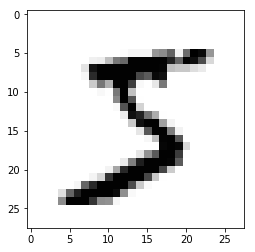

In [2]:
sample_image = mnist[0]
print(sample_image.shape)

sample_image = sample_image.reshape([28, 28])
plt.imshow(sample_image, cmap='Greys')

If you run the cell above again, you'll see a different image from the MNIST training set.

## Discriminator network

Our discriminator is a convolutional neural network that takes in an image of size 28 x 28 x 1 as input and returns a single scalar number that describes whether or not the input image is "real" or "fake"—that is, whether it's drawn from the set of MNIST images or generated by the generator.

![caption](notebook-images/GAN_Discriminator.png)

The structure of our discriminator network is based closely on [TensorFlow's sample CNN classifier model](https://www.tensorflow.org/get_started/mnist/pros). It features two convolutional layers that find 5x5-pixel features, and two "fully connected" layers that multiply weights by every pixel in the image.

To set up each layer, we start by creating weight and bias variables through [`tf.get_variable`](https://www.tensorflow.org/api_docs/python/tf/get_variable). Weights are initialized from a [truncated normal](https://www.tensorflow.org/api_docs/python/tf/truncated_normal) distribution, and biases are initialized at zero.

[`tf.nn.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) is TensorFlow's standard convolution function. It takes 4 arguments. The first is the input volume (our `28 x 28 x 1` images in this case). The next argument is the filter/weight matrix. Finally, you can also change the stride and padding of the convolution. Those two values affect the dimensions of the output volume.

If you're already comfortable with CNNs, you'll recognize this as a simple binary classifier—nothing fancy. 

In [3]:
def discriminator(images, reuse_variables=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse_variables) as scope:
        # First convolutional and pool layers
        # This finds 32 different 5 x 5 pixel features
        d_w1 = tf.get_variable('d_w1', [5, 5, 1, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b1 = tf.get_variable('d_b1', [32], initializer=tf.constant_initializer(0))
        d1 = tf.nn.conv2d(input=images, filter=d_w1, strides=[1, 1, 1, 1], padding='SAME')
        d1 = d1 + d_b1
        d1 = tf.nn.relu(d1)
        d1 = tf.nn.avg_pool(d1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional and pool layers
        # This finds 64 different 5 x 5 pixel features
        d_w2 = tf.get_variable('d_w2', [5, 5, 32, 64], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b2 = tf.get_variable('d_b2', [64], initializer=tf.constant_initializer(0))
        d2 = tf.nn.conv2d(input=d1, filter=d_w2, strides=[1, 1, 1, 1], padding='SAME')
        d2 = d2 + d_b2
        d2 = tf.nn.relu(d2)
        d2 = tf.nn.avg_pool(d2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

        # First fully connected layer
        d_w3 = tf.get_variable('d_w3', [7 * 7 * 64, 1024], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b3 = tf.get_variable('d_b3', [1024], initializer=tf.constant_initializer(0))
        d3 = tf.reshape(d2, [-1, 7 * 7 * 64])
        d3 = tf.matmul(d3, d_w3)
        d3 = d3 + d_b3
        d3 = tf.nn.relu(d3)

        # Second fully connected layer
        d_w4 = tf.get_variable('d_w4', [1024, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        d_b4 = tf.get_variable('d_b4', [1], initializer=tf.constant_initializer(0))
        d4 = tf.matmul(d3, d_w4) + d_b4

        # d4 contains unscaled values
        return d4

## Generator network

![caption](notebook-images/GAN_Generator.png)

Now that we have our discriminator defined, let’s take a look at the generator model. We'll base the overall structure of our model on a simple generator published by [Tim O'Shea](https://github.com/osh/KerasGAN).

You can think of the generator as a kind of reverse convolutional neural network. A typical CNN like our discriminator network transforms a 2- or 3-dimensional matrix of pixel values into a single probability. A generator, however, takes a `d`-dimensional vector of noise and upsamples it to become a 28 x 28 image. ReLU and batch normalization are used to stabilize the outputs of each layer.

In our generator network, we use three convolutional layers along with interpolation until a `28 x 28` pixel image is formed. (Actually, as you'll see below, we've taken care to form `28 x 28 x 1` images; many TensorFlow tools for dealing with images anticipate that the images will have some number of _channels_—usually 1 for greyscale images or 3 for RGB color images.)

At the output layer we add a [`tf.sigmoid()`](https://www.tensorflow.org/api_docs/python/tf/sigmoid) activation function; this squeezes pixels that would appear grey toward either black or white, resulting in a crisper image.

In [4]:
def generator(z, batch_size, z_dim):
    g_w1 = tf.get_variable('g_w1', [z_dim, 3136], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b1 = tf.get_variable('g_b1', [3136], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g1 = tf.matmul(z, g_w1) + g_b1
    g1 = tf.reshape(g1, [-1, 56, 56, 1])
    g1 = tf.contrib.layers.batch_norm(g1, epsilon=1e-5, scope='g_b1')
    g1 = tf.nn.relu(g1)

    # Generate 50 features
    g_w2 = tf.get_variable('g_w2', [3, 3, 1, z_dim/2], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b2 = tf.get_variable('g_b2', [z_dim/2], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g2 = tf.nn.conv2d(g1, g_w2, strides=[1, 2, 2, 1], padding='SAME')
    g2 = g2 + g_b2
    g2 = tf.contrib.layers.batch_norm(g2, epsilon=1e-5, scope='g_b2')
    g2 = tf.nn.relu(g2)
    g2 = tf.image.resize_images(g2, [56, 56])

    # Generate 25 features
    g_w3 = tf.get_variable('g_w3', [3, 3, z_dim/2, z_dim/4], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b3 = tf.get_variable('g_b3', [z_dim/4], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g3 = tf.nn.conv2d(g2, g_w3, strides=[1, 2, 2, 1], padding='SAME')
    g3 = g3 + g_b3
    g3 = tf.contrib.layers.batch_norm(g3, epsilon=1e-5, scope='g_b3')
    g3 = tf.nn.relu(g3)
    g3 = tf.image.resize_images(g3, [56, 56])

    # Final convolution with one output channel
    g_w4 = tf.get_variable('g_w4', [1, 1, z_dim/4, 1], dtype=tf.float32, initializer=tf.truncated_normal_initializer(stddev=0.02))
    g_b4 = tf.get_variable('g_b4', [1], initializer=tf.truncated_normal_initializer(stddev=0.02))
    g4 = tf.nn.conv2d(g3, g_w4, strides=[1, 2, 2, 1], padding='SAME')
    g4 = g4 + g_b4
    g4 = tf.sigmoid(g4)
    
    # Dimensions of g4: batch_size x 28 x 28 x 1
    return g4

The original notebook used the "next_batch" function built into the result of loading MINST data with the older, now depreated TensorFlow API. This method is a replacement for the absence of "next_batch" in the newer way of loading MINST data.

In [5]:
def nextBatch(num, data):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]

    return np.asarray(data_shuffle)

## Generating a sample image

Now we’ve defined both the generator and discriminator functions. Let’s see what a sample output from an untrained generator looks like.

We need to open a TensorFlow session and create a placeholder for the input to our generator. The shape of the placeholder will be `None, z_dimensions`. The `None` keyword means that the value can be determined at session runtime. We normally have `None` as our first dimension so that we can have variable batch sizes. (With a batch size of 50, the input to the generator would be 50 x 100). With the `None` keywoard, we don't have to specify `batch_size` until later. 

In [6]:
z_dimensions = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

Now, we create a variable (`generated_image_output`) that holds the output of the generator, and we'll also initialize the random noise vector that we're going to use as input. The [`np.random.normal()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) function has three arguments. The first and second define the mean and standard deviation for the normal distribution (0 and 1 in our case), and the third defines the the shape of the vector (`1 x 100`).

In [7]:
generated_image_output = generator(z_placeholder, 1, z_dimensions)
z_batch = np.random.normal(0, 1, [1, z_dimensions])

Instructions for updating:
Colocations handled automatically by placer.


Next, we initialize all the variables, feed our `z_batch` into the placeholder, and run the session.

The [`sess.run()`](https://www.tensorflow.org/api_docs/python/tf/Session#run) function has two arguments. The first is called the "fetches" argument; it defines the value you're interested in computing. In our case, we want to see what the output of the generator is. If you look back at the last code snippet, you'll see that the output of the generator function is stored in `generated_image_output`, so we'll use `generated_image_output` for our first argument.

The second argument takes a dictionary of inputs that are substituted into the graph when it runs. This is where we feed in our placeholders. In our example, we need to feed our `z_batch` variable into the `z_placeholder` that we defined earlier. As before, we'll view the image by reshaping it to `28 x 28` pixels and show it with PyPlot.

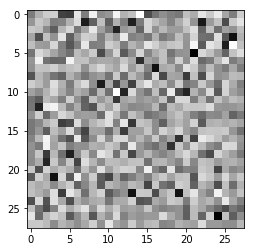

In [8]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    generated_image = sess.run(generated_image_output,
                                feed_dict={z_placeholder: z_batch})
    generated_image = generated_image.reshape([28, 28])
    plt.imshow(generated_image, cmap='Greys')

That looks like noise, right? Now we need to train the weights and biases in the generator network to convert random numbers into recognizable digits. Let's look at loss functions and optimization!

## Training a GAN

One of the trickiest parts about building and tuning GANs is that they have two loss functions: one that encourages the generator to create better images, and the other that encourages the discriminator to distinguish generated images from real images.

We train both the generator and the discriminator simultaneously. As the discriminator gets better at distinguishing real images from generated images, the generator is able to better tune its weights and biases to generate convincing images.

Here are the inputs and outputs for our networks.

In [9]:
tf.reset_default_graph()
batch_size = 50

z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
# z_placeholder is for feeding input noise to the generator

x_placeholder = tf.placeholder(tf.float32, shape = [None,28,28,1], name='x_placeholder') 
# x_placeholder is for feeding input images to the discriminator

Gz = generator(z_placeholder, batch_size, z_dimensions) 
# Gz holds the generated images

Dx = discriminator(x_placeholder) 
# Dx will hold discriminator prediction probabilities
# for the real MNIST images

Dg = discriminator(Gz, reuse_variables=True)
# Dg will hold discriminator prediction probabilities for generated images

So, let’s first think about what we want out of our networks. The discriminator's goal is to correctly label real MNIST images as real (return a higher output) and generated images as fake (return a lower output). We'll calculate two losses for the discriminator: one loss that compares `Dx` and 1 for real images from the MNIST set, as well as a loss that compares `Dg` and 0 for images from the generator. We'll do this with TensorFlow's [`tf.nn.sigmoid_cross_entropy_with_logits()`](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) function, which calculates the cross-entropy losses between `Dx` and 1 and between `Dg` and 0.

`sigmoid_cross_entropy_with_logits` operates on unscaled values rather than probability values from 0 to 1. Take a look at the last line of our discriminator: there's no softmax or sigmoid layer at the end. GANs can fail if their discriminators "saturate," or become confident enough to return exactly 0 when they're given a generated image; that leaves the discriminator without a useful gradient to descend.

The [`tf.reduce_mean()`](https://www.tensorflow.org/api_docs/python/tf/reduce_mean) function takes the mean value of all of the components in the matrix returned by the cross entropy function. This is a way of reducing the loss to a single scalar value, instead of a vector or matrix.

In [10]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dx, labels = tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.zeros_like(Dg)))

Now let's set up the generator's loss function. We want the generator network to create images that will fool the discriminator: the generator wants the discriminator to output a value close to 1 when it's given an image from the generator. Therefore, we want to compute the loss between `Dg` and 1.

In [11]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = Dg, labels = tf.ones_like(Dg)))  

Now that we have our loss functions, we need to define our optimizers. The optimizer for the generator network needs to only update the generator’s weights, not those of the discriminator. Likewise, when we train the discriminator, we want to hold the generator's weights fixed.

In order to make this distinction, we need to create two lists of variables, one with the discriminator’s weights and biases and another with the generator’s weights and biases. This is where naming all of your TensorFlow variables with a thoughtful scheme can come in handy.

In [12]:
tvars = tf.trainable_variables()

d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

print([v.name for v in d_vars])
print([v.name for v in g_vars])

['d_w1:0', 'd_b1:0', 'd_w2:0', 'd_b2:0', 'd_w3:0', 'd_b3:0', 'd_w4:0', 'd_b4:0']
['g_w1:0', 'g_b1:0', 'g_b1/beta:0', 'g_w2:0', 'g_b2:0', 'g_b2/beta:0', 'g_w3:0', 'g_b3:0', 'g_b3/beta:0', 'g_w4:0', 'g_b4:0']


Next, we specify our two optimizers. [Adam](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer) is usually the optimization algorithm of choice for GANs; it utilizes adaptive learning rates and momentum. We call Adam's minimize function and also specify the variables that we want it to update—the generator's weights and biases when we train the generator, and the discriminator's weights and biases when we train the discriminator.

We're setting up two different training operations for the discriminator here: one that trains the discriminator on real images and one that trains the discrmnator on fake images. It's sometimes useful to use different learning rates for these two training operations, or to use them separately to [regulate learning in other ways](https://github.com/jonbruner/ezgan).

In [13]:
# Train the discriminator
d_trainer_fake = tf.train.AdamOptimizer(0.0003).minimize(d_loss_fake, var_list=d_vars)
d_trainer_real = tf.train.AdamOptimizer(0.0003).minimize(d_loss_real, var_list=d_vars)

# Train the generator
g_trainer = tf.train.AdamOptimizer(0.0001).minimize(g_loss, var_list=g_vars)

It can be tricky to get GANs to converge, and moreover they often need to train for a very long time. [TensorBoard](https://www.tensorflow.org/how_tos/summaries_and_tensorboard/) is useful for tracking the training process; it can graph scalar properties like losses, display sample images during training, and illustrate the topology of the neural networks.

If you run this script on your own machine, include the cell below. Then, in a terminal window from the directory that this notebook lives in, run

```
tensorboard --logdir=tensorboard/
```

and open TensorBoard by visiting [`http://localhost:6006`](http://localhost:6006) in your web browser.

In [14]:
# From this point forward, reuse variables
tf.get_variable_scope().reuse_variables()

tf.summary.scalar('Generator_loss', g_loss)
tf.summary.scalar('Discriminator_loss_real', d_loss_real)
tf.summary.scalar('Discriminator_loss_fake', d_loss_fake)

images_for_tensorboard = generator(z_placeholder, batch_size, z_dimensions)
tf.summary.image('Generated_images', images_for_tensorboard, 5)
merged = tf.summary.merge_all()
logdir = "tensorboard/"
writer = tf.summary.FileWriter(logdir, sess.graph)

And now we iterate. We begin by briefly giving the discriminator some initial training; this helps it develop a gradient that's useful to the generator.

Then we move on to the main training loop. When we train the generator, we’ll feed a random `z` vector into the generator and pass its output to the discriminator (this is the `Dg` variable we specified earlier). The generator’s weights and biases will be updated in order to produce images that the discriminator is more likely to classify as real.

To train the discriminator, we’ll feed it a batch of images from the MNIST set to serve as the positive examples, and then train the discriminator again on generated images, using them as negative examples. Remember that as the generator improves its output, the discriminator continues to learn to classify the improved generator images as fake.

Because it takes a long time to train a GAN, **we recommend not running this code block if you're going through this tutorial for the first time**. Instead, follow along but then run the following code block, which loads a pre-trained model for us to continue the tutorial.

**If you want to run this code yourself, prepare to wait: it takes about three hours on a fast GPU, but could take ten times that long on a desktop CPU.**

dLossReal: 0.88387 dLossFake: 0.715789
dLossReal: 4.4069157e-09 dLossFake: 0.009309915
dLossReal: 2.4357797e-26 dLossFake: 5.443674e-05
Iteration: 0 at 2019-05-04 11:06:28.273774


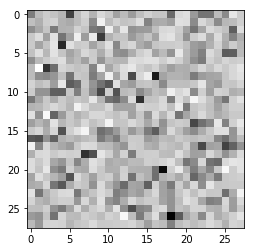

Estimate: [[-10.416647]]
Iteration: 100 at 2019-05-04 11:07:02.287292


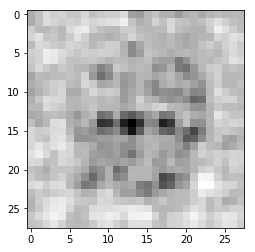

Estimate: [[-10.529424]]
Iteration: 200 at 2019-05-04 11:07:35.791695


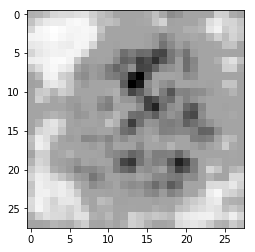

Estimate: [[-13.195712]]
Iteration: 300 at 2019-05-04 11:08:09.819187


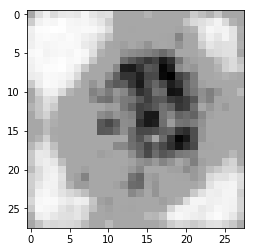

Estimate: [[-11.599362]]
Iteration: 400 at 2019-05-04 11:08:43.817766


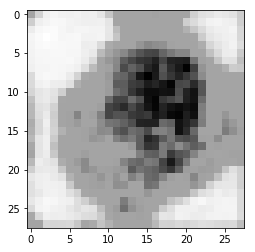

Estimate: [[-11.425147]]
Iteration: 500 at 2019-05-04 11:09:18.190292


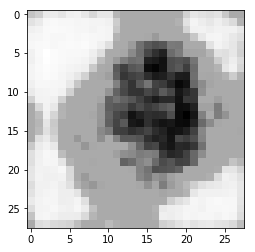

Estimate: [[-11.686042]]
Iteration: 600 at 2019-05-04 11:09:52.535794


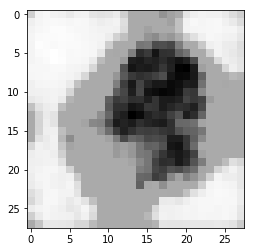

Estimate: [[-8.91299]]
Iteration: 700 at 2019-05-04 11:10:26.146599


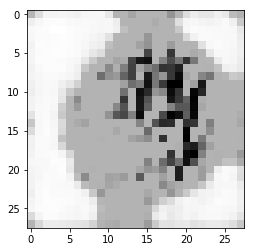

Estimate: [[-10.040224]]
Iteration: 800 at 2019-05-04 11:11:00.268484


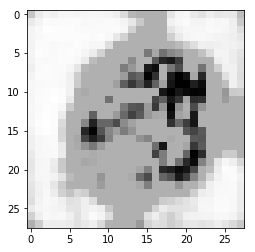

Estimate: [[-9.458067]]
Iteration: 900 at 2019-05-04 11:11:34.247947


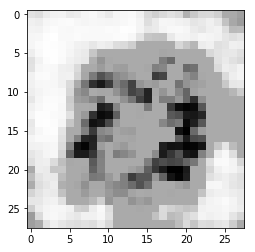

Estimate: [[-10.074519]]
Iteration: 1000 at 2019-05-04 11:12:07.983095


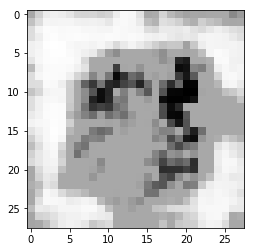

Estimate: [[-10.654003]]
Iteration: 1100 at 2019-05-04 11:12:42.052241


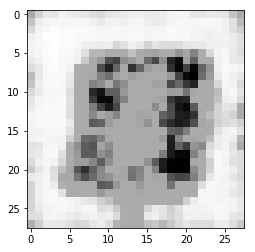

Estimate: [[-10.415359]]
Iteration: 1200 at 2019-05-04 11:13:16.006367


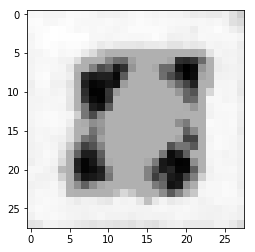

Estimate: [[-10.198054]]
Iteration: 1300 at 2019-05-04 11:13:49.959428


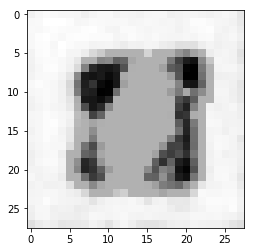

Estimate: [[-10.078657]]
Iteration: 1400 at 2019-05-04 11:14:23.844985


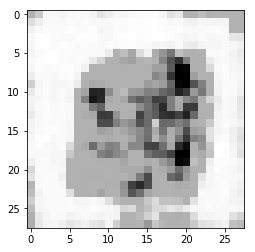

Estimate: [[-10.074403]]
Iteration: 1500 at 2019-05-04 11:14:58.415107


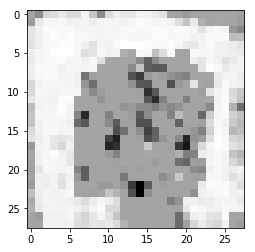

Estimate: [[-10.49816]]
Iteration: 1600 at 2019-05-04 11:15:31.800183


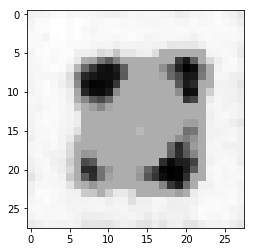

Estimate: [[-8.9877205]]
Iteration: 1700 at 2019-05-04 11:16:05.389838


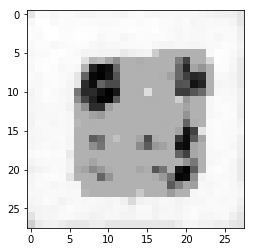

Estimate: [[-9.405558]]
Iteration: 1800 at 2019-05-04 11:16:38.840167


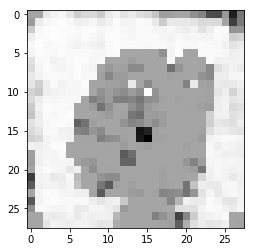

Estimate: [[-10.039572]]
Iteration: 1900 at 2019-05-04 11:17:12.314466


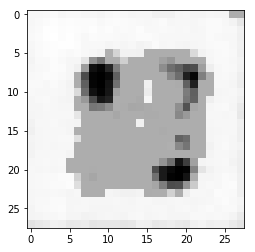

Estimate: [[-9.182244]]
Iteration: 2000 at 2019-05-04 11:17:45.810358


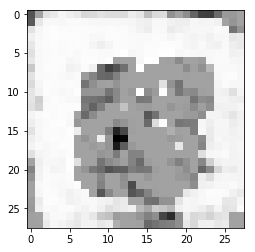

Estimate: [[-10.261531]]
Iteration: 2100 at 2019-05-04 11:18:19.083614


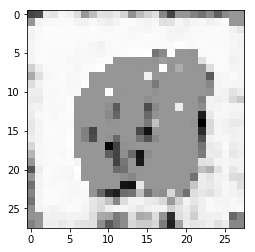

Estimate: [[-10.841903]]
Iteration: 2200 at 2019-05-04 11:18:52.417155


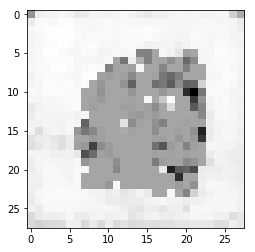

Estimate: [[-10.404332]]
Iteration: 2300 at 2019-05-04 11:19:25.879419


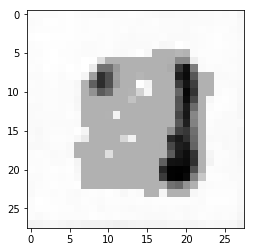

Estimate: [[-10.323078]]
Iteration: 2400 at 2019-05-04 11:19:59.256766


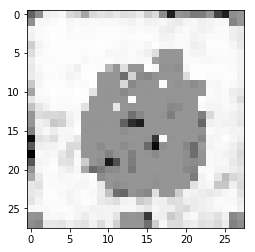

Estimate: [[-10.35271]]
Iteration: 2500 at 2019-05-04 11:20:32.755833


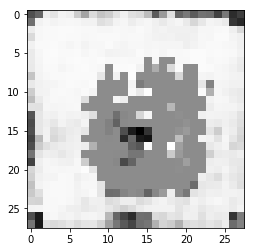

Estimate: [[-10.226191]]
Iteration: 2600 at 2019-05-04 11:21:06.321958


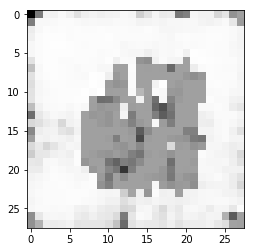

Estimate: [[-10.205261]]
Iteration: 2700 at 2019-05-04 11:21:39.808787


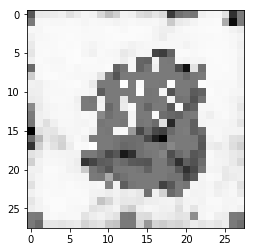

Estimate: [[-10.382624]]
Iteration: 2800 at 2019-05-04 11:22:13.398846


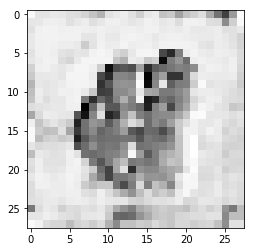

Estimate: [[-16.72147]]
Iteration: 2900 at 2019-05-04 11:22:46.914312


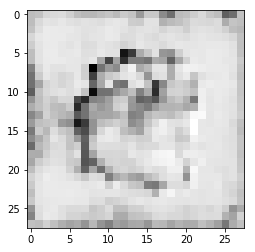

Estimate: [[-15.805998]]
Iteration: 3000 at 2019-05-04 11:23:20.900110


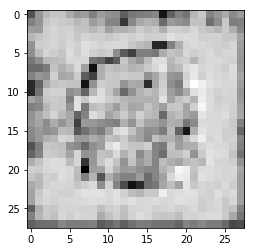

Estimate: [[-15.797174]]
Iteration: 3100 at 2019-05-04 11:23:55.015966


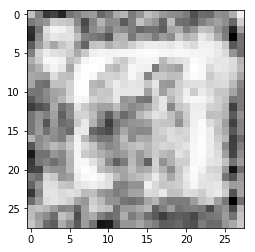

Estimate: [[-17.463734]]
Iteration: 3200 at 2019-05-04 11:24:29.105434


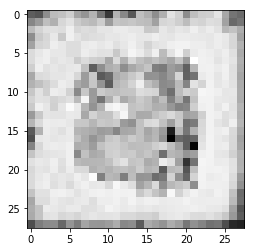

Estimate: [[-16.799967]]
Iteration: 3300 at 2019-05-04 11:25:03.201611


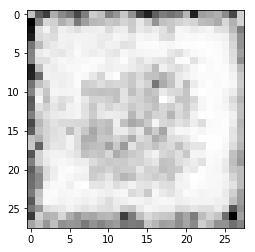

Estimate: [[-17.099756]]
Iteration: 3400 at 2019-05-04 11:25:37.512752


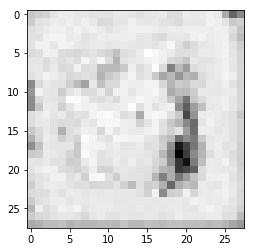

Estimate: [[-17.796896]]
Iteration: 3500 at 2019-05-04 11:26:11.732229


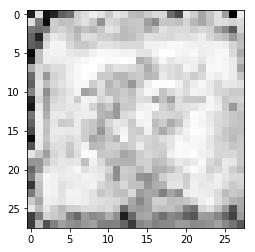

Estimate: [[-18.05791]]
Iteration: 3600 at 2019-05-04 11:26:45.752805


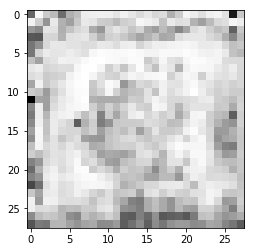

Estimate: [[-18.698395]]
Iteration: 3700 at 2019-05-04 11:27:20.064546


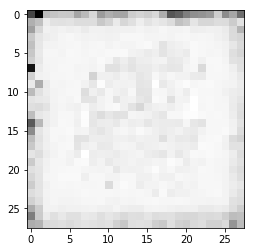

Estimate: [[-17.904505]]
Iteration: 3800 at 2019-05-04 11:27:54.275369


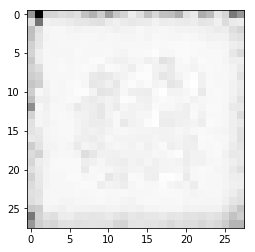

Estimate: [[-16.044752]]
Iteration: 3900 at 2019-05-04 11:28:28.245670


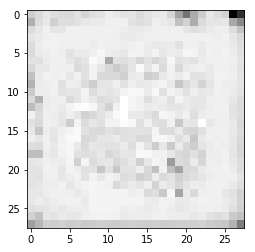

Estimate: [[-17.92423]]
Iteration: 4000 at 2019-05-04 11:29:02.724524


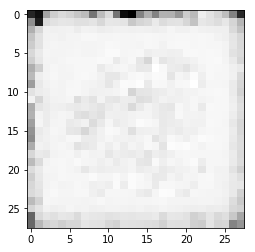

Estimate: [[-18.440254]]
Iteration: 4100 at 2019-05-04 11:29:37.175788


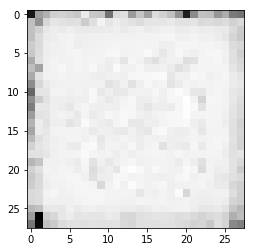

Estimate: [[-18.70503]]
Iteration: 4200 at 2019-05-04 11:30:11.340854


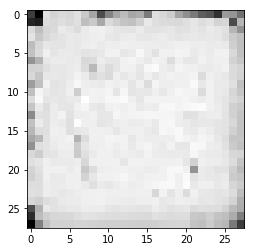

Estimate: [[-18.963139]]
Iteration: 4300 at 2019-05-04 11:30:45.474479


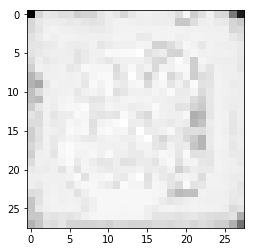

Estimate: [[-19.12916]]
Iteration: 4400 at 2019-05-04 11:31:19.397852


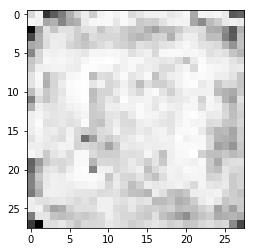

Estimate: [[-19.775045]]
Iteration: 4500 at 2019-05-04 11:31:53.607763


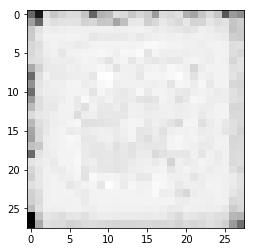

Estimate: [[-19.40528]]
Iteration: 4600 at 2019-05-04 11:32:27.790153


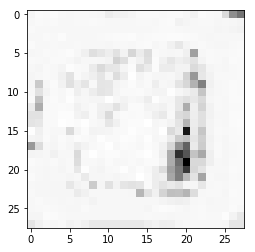

Estimate: [[-19.947735]]
Iteration: 4700 at 2019-05-04 11:33:02.290558


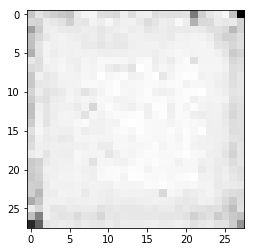

Estimate: [[-19.87481]]
Iteration: 4800 at 2019-05-04 11:33:36.392613


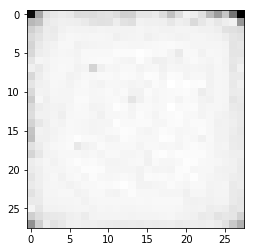

Estimate: [[-19.79793]]
Iteration: 4900 at 2019-05-04 11:34:10.846514


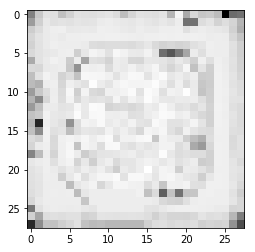

Estimate: [[-19.932028]]
Iteration: 5000 at 2019-05-04 11:34:44.769420


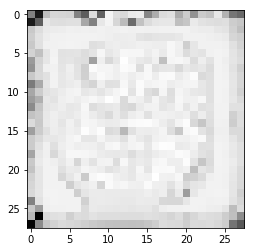

Estimate: [[-20.011362]]
Iteration: 5100 at 2019-05-04 11:35:19.072802


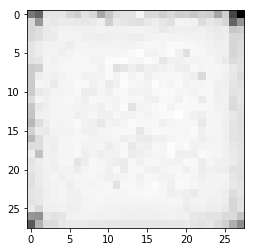

Estimate: [[-20.104916]]
Iteration: 5200 at 2019-05-04 11:35:53.343118


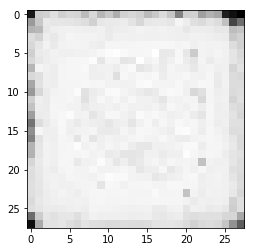

Estimate: [[-20.208815]]
Iteration: 5300 at 2019-05-04 11:36:27.751207


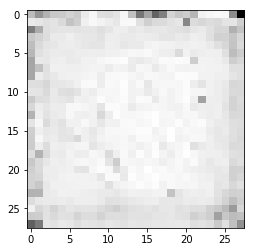

Estimate: [[-20.47894]]
Iteration: 5400 at 2019-05-04 11:37:02.132551


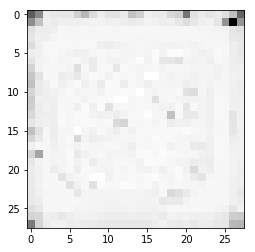

Estimate: [[-20.42233]]
Iteration: 5500 at 2019-05-04 11:37:36.495511


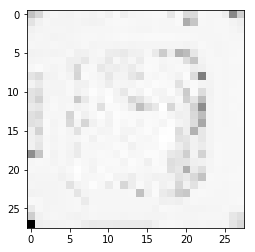

Estimate: [[-20.596615]]
Iteration: 5600 at 2019-05-04 11:38:11.063750


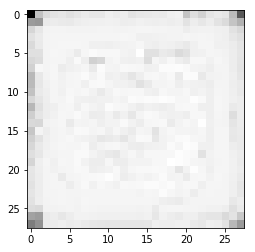

Estimate: [[-20.583948]]
Iteration: 5700 at 2019-05-04 11:38:45.249551


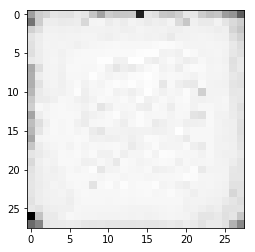

Estimate: [[-20.677309]]
Iteration: 5800 at 2019-05-04 11:39:19.319601


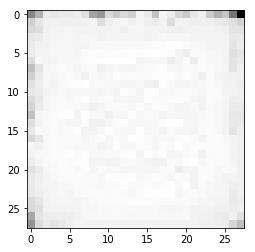

Estimate: [[-20.7685]]
Iteration: 5900 at 2019-05-04 11:39:53.245712


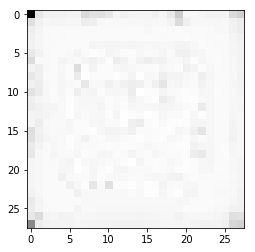

Estimate: [[-20.85007]]
Iteration: 6000 at 2019-05-04 11:40:27.197968


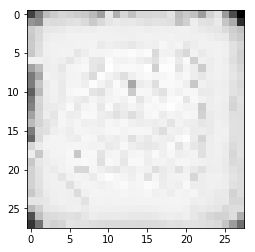

Estimate: [[-20.909409]]
Iteration: 6100 at 2019-05-04 11:41:01.471278


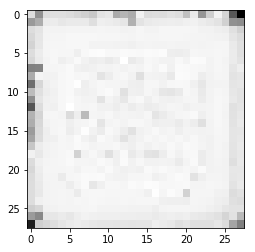

Estimate: [[-20.99357]]
Iteration: 6200 at 2019-05-04 11:41:35.651105


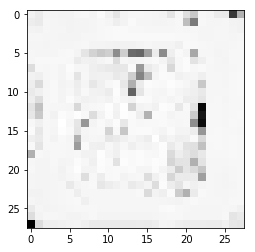

Estimate: [[-21.142208]]
Iteration: 6300 at 2019-05-04 11:42:09.934311


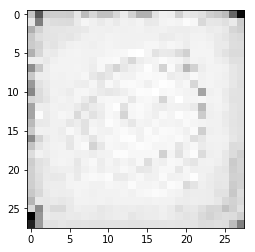

Estimate: [[-21.180937]]
Iteration: 6400 at 2019-05-04 11:42:44.019600


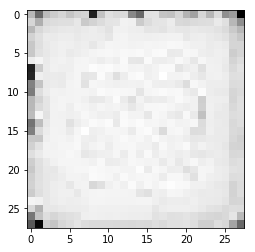

Estimate: [[-21.219679]]
Iteration: 6500 at 2019-05-04 11:43:18.572089


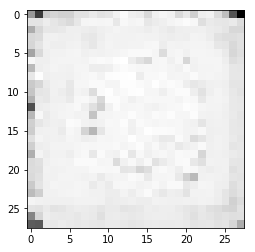

Estimate: [[-21.3497]]
Iteration: 6600 at 2019-05-04 11:43:53.011843


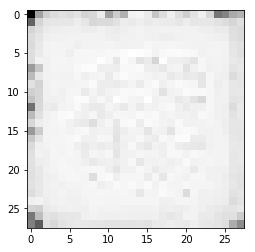

Estimate: [[-21.35056]]
Iteration: 6700 at 2019-05-04 11:44:27.454822


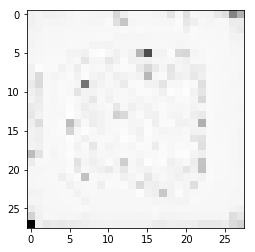

Estimate: [[-21.431993]]
Iteration: 6800 at 2019-05-04 11:45:01.793684


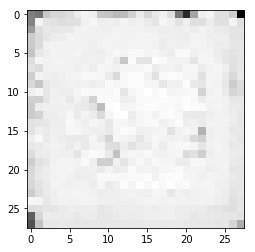

Estimate: [[-21.535975]]
Iteration: 6900 at 2019-05-04 11:45:36.112507


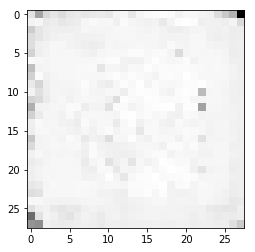

Estimate: [[-21.60073]]
Iteration: 7000 at 2019-05-04 11:46:10.606156


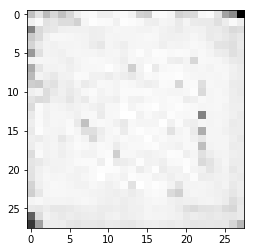

Estimate: [[-21.667753]]
Iteration: 7100 at 2019-05-04 11:46:45.021462


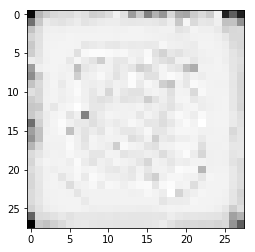

Estimate: [[-21.659943]]
Iteration: 7200 at 2019-05-04 11:47:19.464768


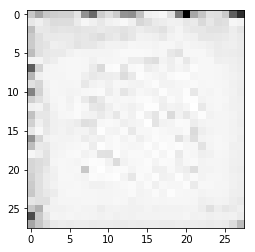

Estimate: [[-21.757082]]
Iteration: 7300 at 2019-05-04 11:47:53.767316


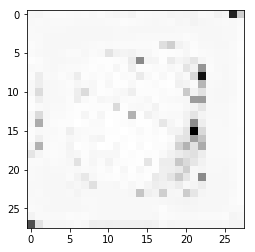

Estimate: [[-21.873331]]
Iteration: 7400 at 2019-05-04 11:48:28.068092


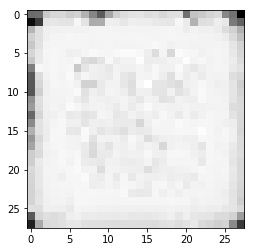

Estimate: [[-21.834555]]
Iteration: 7500 at 2019-05-04 11:49:02.633543


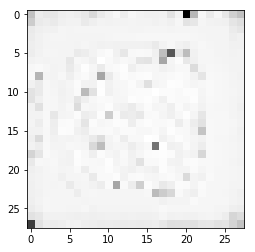

Estimate: [[-21.908802]]
Iteration: 7600 at 2019-05-04 11:49:37.495601


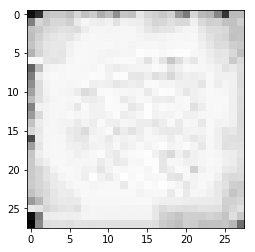

Estimate: [[-21.964016]]
Iteration: 7700 at 2019-05-04 11:50:11.972087


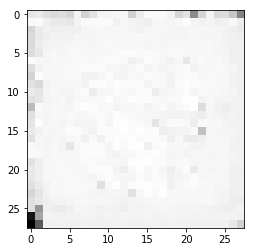

Estimate: [[-22.039467]]
Iteration: 7800 at 2019-05-04 11:50:46.187612


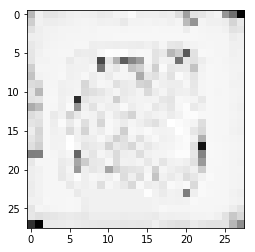

Estimate: [[-22.071993]]
Iteration: 7900 at 2019-05-04 11:51:20.677947


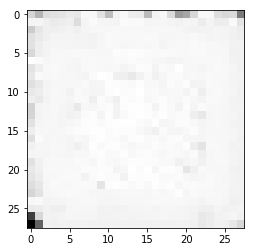

Estimate: [[-22.145084]]
Iteration: 8000 at 2019-05-04 11:51:55.232640


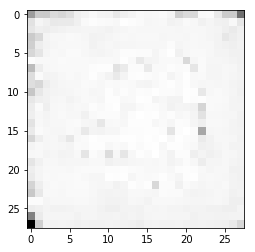

Estimate: [[-22.204866]]
Iteration: 8100 at 2019-05-04 11:52:29.871903


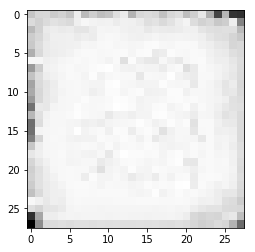

Estimate: [[-22.223682]]
Iteration: 8200 at 2019-05-04 11:53:04.721440


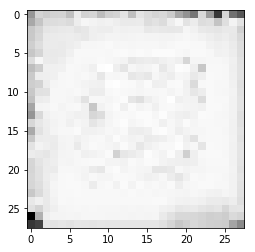

Estimate: [[-22.275936]]
Iteration: 8300 at 2019-05-04 11:53:39.451397


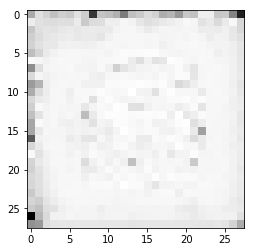

Estimate: [[-22.33346]]
Iteration: 8400 at 2019-05-04 11:54:13.962190


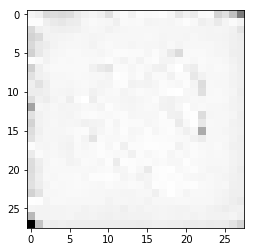

Estimate: [[-22.387402]]
Iteration: 8500 at 2019-05-04 11:54:48.162367


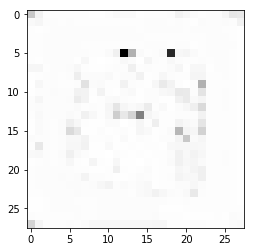

Estimate: [[-22.477276]]
Iteration: 8600 at 2019-05-04 11:55:22.638800


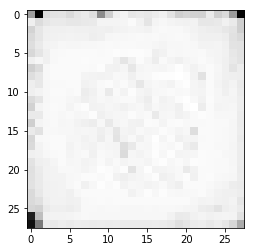

Estimate: [[-22.467113]]
Iteration: 8700 at 2019-05-04 11:55:57.197799


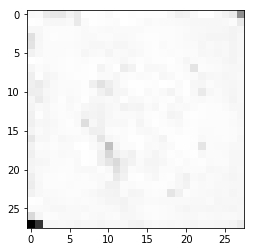

Estimate: [[-22.550974]]
Iteration: 8800 at 2019-05-04 11:56:32.064230


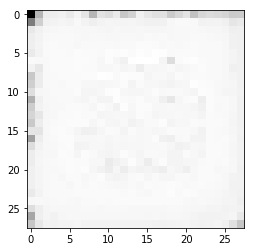

Estimate: [[-22.55576]]
Iteration: 8900 at 2019-05-04 11:57:06.584032


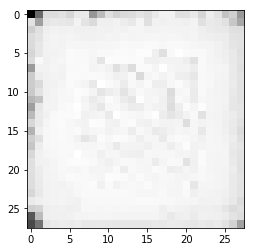

Estimate: [[-22.601473]]
Iteration: 9000 at 2019-05-04 11:57:40.998432


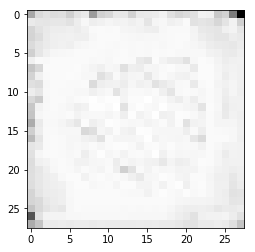

Estimate: [[-22.656395]]
Iteration: 9100 at 2019-05-04 11:58:15.649058


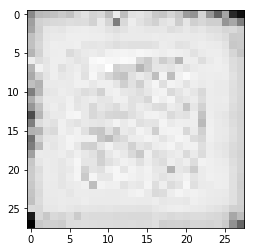

Estimate: [[-22.69298]]
Iteration: 9200 at 2019-05-04 11:58:49.973078


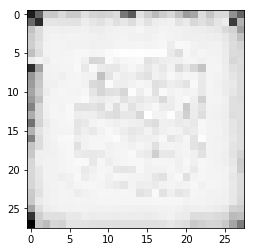

Estimate: [[-22.735985]]
Iteration: 9300 at 2019-05-04 11:59:24.555775


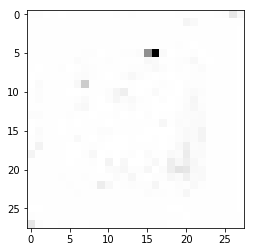

Estimate: [[-22.82948]]
Iteration: 9400 at 2019-05-04 11:59:59.048511


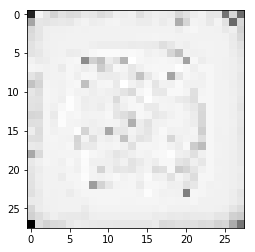

Estimate: [[-22.82718]]
Iteration: 9500 at 2019-05-04 12:00:33.604763


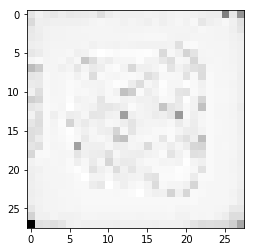

Estimate: [[-22.870226]]
Iteration: 9600 at 2019-05-04 12:01:08.071727


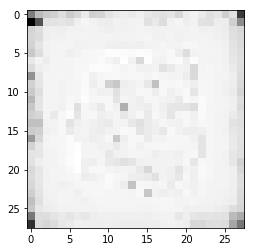

Estimate: [[-22.910297]]
Iteration: 9700 at 2019-05-04 12:01:42.733473


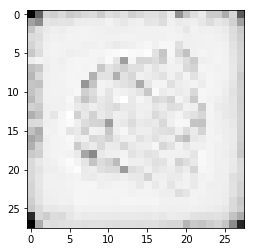

Estimate: [[-22.952452]]
Iteration: 9800 at 2019-05-04 12:02:17.324611


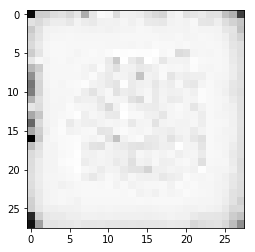

Estimate: [[-22.992792]]
Iteration: 9900 at 2019-05-04 12:02:51.969640


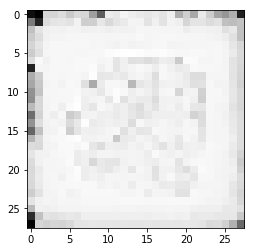

Estimate: [[-23.033777]]
Iteration: 10000 at 2019-05-04 12:03:26.535195


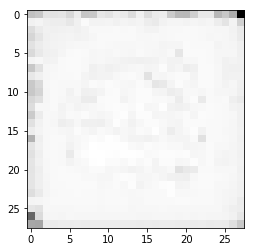

Estimate: [[-23.082954]]
Iteration: 10100 at 2019-05-04 12:04:01.252457


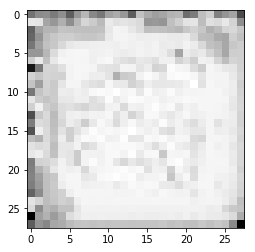

Estimate: [[-23.119223]]
Iteration: 10200 at 2019-05-04 12:04:35.796778


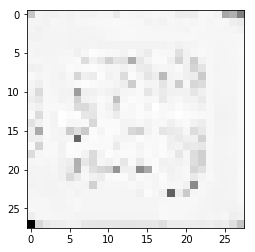

Estimate: [[-23.162321]]
Iteration: 10300 at 2019-05-04 12:05:10.346091


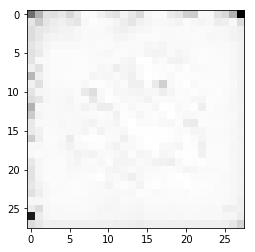

Estimate: [[-23.20242]]
Iteration: 10400 at 2019-05-04 12:05:45.004818


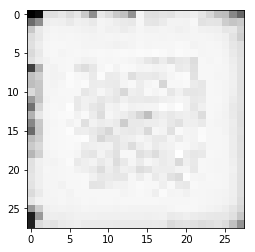

Estimate: [[-23.232605]]
Iteration: 10500 at 2019-05-04 12:06:19.542014


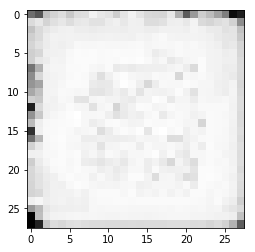

Estimate: [[-23.271101]]
Iteration: 10600 at 2019-05-04 12:06:54.170911


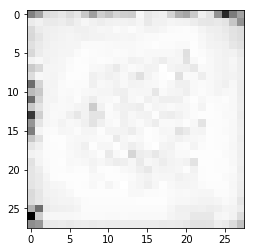

Estimate: [[-23.312767]]
Iteration: 10700 at 2019-05-04 12:07:28.990168


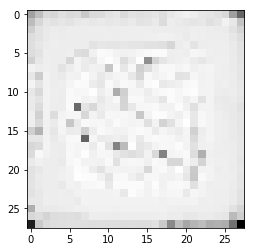

Estimate: [[-23.348118]]
Iteration: 10800 at 2019-05-04 12:08:03.764322


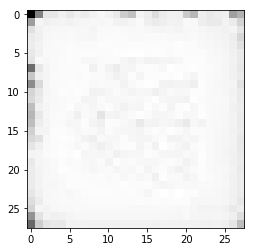

Estimate: [[-23.383545]]
Iteration: 10900 at 2019-05-04 12:08:38.264252


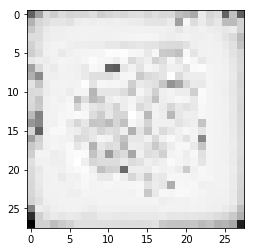

Estimate: [[-23.421278]]
Iteration: 11000 at 2019-05-04 12:09:12.678995


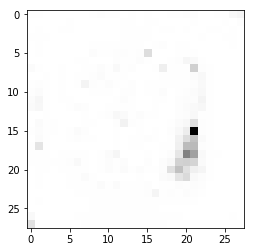

Estimate: [[-23.52203]]
Iteration: 11100 at 2019-05-04 12:09:47.486746


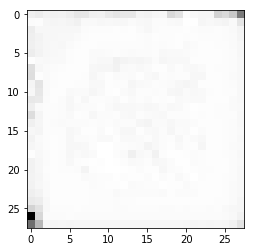

Estimate: [[-23.498745]]
Iteration: 11200 at 2019-05-04 12:10:21.737455


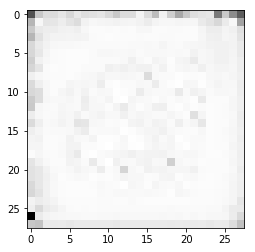

Estimate: [[-23.533382]]
Iteration: 11300 at 2019-05-04 12:10:56.502460


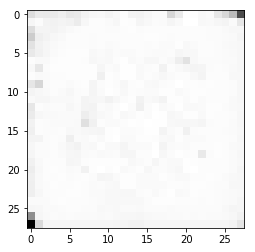

Estimate: [[-23.57015]]
Iteration: 11400 at 2019-05-04 12:11:31.124864


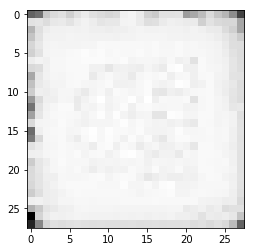

Estimate: [[-23.59936]]
Iteration: 11500 at 2019-05-04 12:12:06.371600


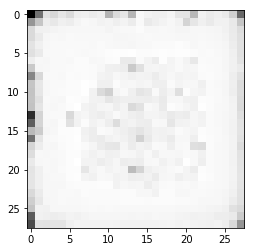

Estimate: [[-23.634306]]
Iteration: 11600 at 2019-05-04 12:12:41.239846


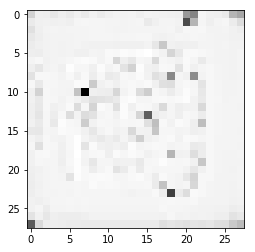

Estimate: [[-23.670156]]
Iteration: 11700 at 2019-05-04 12:13:17.039286


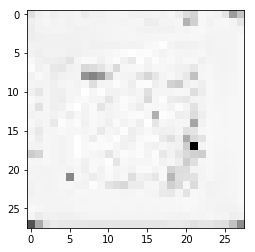

Estimate: [[-23.705173]]
Iteration: 11800 at 2019-05-04 12:13:51.866569


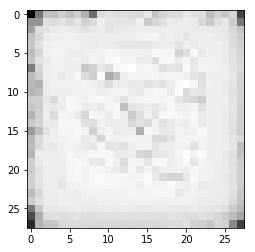

Estimate: [[-23.735907]]
Iteration: 11900 at 2019-05-04 12:14:26.495018


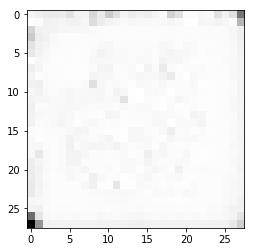

Estimate: [[-23.773407]]
Iteration: 12000 at 2019-05-04 12:15:01.822718


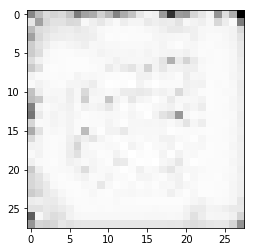

Estimate: [[-23.80615]]


KeyboardInterrupt: 

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Pre-train discriminator
for i in range(300):
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    real_image_batch = nextBatch(batch_size, mnist).reshape([batch_size, 28, 28, 1])
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    if(i % 100 == 0):
        print("dLossReal:", dLossReal, "dLossFake:", dLossFake)

# Train generator and discriminator together
for i in range(100000):
    real_image_batch = nextBatch(batch_size, mnist).reshape([batch_size, 28, 28, 1])
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])

    # Train discriminator on both real and fake images
    _, __, dLossReal, dLossFake = sess.run([d_trainer_real, d_trainer_fake, d_loss_real, d_loss_fake],
                                           {x_placeholder: real_image_batch, z_placeholder: z_batch})

    # Train generator
    z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
    _ = sess.run(g_trainer, feed_dict={z_placeholder: z_batch})

    if i % 10 == 0:
        # Update TensorBoard with summary statistics
        z_batch = np.random.normal(0, 1, size=[batch_size, z_dimensions])
        summary = sess.run(merged, {z_placeholder: z_batch, x_placeholder: real_image_batch})
        writer.add_summary(summary, i)

    if i % 100 == 0:
        # Every 100 iterations, show a generated image
        print("Iteration:", i, "at", datetime.datetime.now())
        z_batch = np.random.normal(0, 1, size=[1, z_dimensions])
        generated_images = generator(z_placeholder, 1, z_dimensions)
        images = sess.run(generated_images, {z_placeholder: z_batch})
        plt.imshow(images[0].reshape([28, 28]), cmap='Greys')
        plt.show()

        # Show discriminator's estimate
        im = images[0].reshape([1, 28, 28, 1])
        result = discriminator(x_placeholder)
        estimate = sess.run(result, {x_placeholder: im})
        print("Estimate:", estimate)

Because it can take so long to train a GAN, we recommend that you skip the cell above and execute the following cell. It loads a model that we've already trained for several hours on a fast GPU machine, and lets you experiment with the output of a trained GAN.

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'pretrained-model/pretrained_gan.ckpt')
    z_batch = np.random.normal(0, 1, size=[10, z_dimensions])
    z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions], name='z_placeholder') 
    generated_images = generator(z_placeholder, 10, z_dimensions)
    images = sess.run(generated_images, {z_placeholder: z_batch})
    for i in range(10):
        plt.imshow(images[i].reshape([28, 28]), cmap='Greys')
        plt.show()

## Training difficulties

GANs are notoriously difficult to train. Without the right hyperparameters, network architecture, and training procedure, the discriminator can overpower the generator, or vice-versa.

In one common failure mode, the discriminator overpowers the generator, classifying generated images as fake with absolute certainty. When the discriminator responds with absolute certainty, it leaves no gradient for the generator to descend. This is partly why we built our discriminator to produce unscaled output rather than passing its output through a sigmoid function that would push its evaluation toward either 0 or 1.

In another common failure mode known as **mode collapse**, the generator discovers and exploits some weakness in the discriminator. You can recognize mode collapse in your GAN if it generates many very similar images regardless of variation in the generator input _z_. Mode collapse can sometimes be corrected by "strengthening" the discriminator in some way—for instance, by adjusting its training rate or by reconfiguring its layers.

Researchers have identified a handful of ["GAN hacks"](https://github.com/soumith/ganhacks) that can be helpful in building stable GANs.

## Closing thoughts

GANs have tremendous potential to reshape the digital world that we interact with every day. The field is still very young, and the next great GAN discovery could be yours!

## Other resources

- [The original GAN paper](https://arxiv.org/abs/1406.2661) by Ian Goodfellow and his collaborators, published in 2014
- [A more recent tutorial by Goodfellow](https://arxiv.org/abs/1701.00160) that explains GANs in somewhat more accessible terms
- [A paper by Alec Radford, Luke Metz, and Soumith Chintala](https://arxiv.org/abs/1511.06434) that introduces deep convolutional GANs, whose basic structure we use in our generator in this tutorial. Also see [their DCGAN code on GitHub](https://github.com/Newmu/dcgan_code).
- [A reference collection of generative networks by Agustinus Kristiadi](https://github.com/wiseodd/generative-models), implemented in TensorFlow